Imports

In [2]:
import argparse
import cv2
import numpy as np
import pandas as pd
from numpy.linalg import svd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from dataset.crossview_dataset import data_utils
from dataset.crossview_dataset.visualization.visualizer import Visualizer
from dataset.crossview_dataset.calib.calibration import Calibration
from matplotlib.patches import Circle

%matplotlib widget
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import time

from scipy.optimize import linear_sum_assignment
from collections import defaultdict, OrderedDict

from scipy.sparse import coo_matrix
from bip_solver import GLPKSolver

import logging
#from tqdm import tqdm
from tqdm.notebook import tqdm

Config

In [6]:
FOLDER = "C:\\Users\\user\\Documents\\Triangulation\\dataset\\Campus_Seq1\\Campus_Seq1\\"
frame_root = os.path.join(FOLDER,"frames")
calibration_file = os.path.join(FOLDER,"calibration.json") 
pose_file = os.path.join(FOLDER,"annotation_2d.json")
cameras = None

frame_loader = data_utils.FrameLoader(frame_root,cameras)
pose_loader = data_utils.Pose2DLoader(pose_file)

# load calibration
calibration = Calibration.from_json(calibration_file)

# 2D correspondence
""" 
Pose anno

0: 'r-ankle',
1: 'r-knee',
2: 'r-hip',
3: 'l-hip',
4: 'l-knee',
5: 'l-ankle',
6: 'r-wrist',
7: 'r-elbow',
8: 'r-shoulder',
9: 'l-shoulder',
10: 'l-elbow',
11: 'l-wrist',
12: 'bottom-head',
13: 'top-head'

"""
delta_time_threshold = 0.1  

w_2D = 0.4  # Weight of 2D correspondence
alpha_2D = 25 # Threshold of 2D velocity
lambda_a = 5  # Penalty rate of time interval
lambda_t = 10

# 3D correspondence
w_3D = 0.6  # Weight of 3D correspondence
alpha_3D = 0.1  # Threshold of distance

## Configure logger
logging.basicConfig(filename='CVT_for_3d_pose_reconstruction.log',encoding='utf-8',level=logging.INFO, filemode = 'w') 

wait_time = 1

no_of_cameras = len(calibration.camera_ids)
world_ltrb = calibration.compute_world_ltrb()

num_body_joints_detected_by_2d_pose_detector = 14
# camera location
camera_id_list = list(calibration.camera_ids)
camera_3d_location = [] 
camera_look_at = []
for cam_index in range(no_of_cameras):
    cam_loc = calibration.cameras[camera_id_list[cam_index]].location
    camera_3d_location.append(cam_loc)
    camera_look_at.append(calibration.cameras[camera_id_list[cam_index]].look_at)
    print(f'Camera id {camera_id_list[cam_index]} | location: {cam_loc}')

Load 6000 frames from ['Camera0', 'Camera1', 'Camera2']
Camera id Camera1 | location: [-624.05799093  524.73482644  194.73802149]
Camera id Camera2 | location: [1194.35610655 -180.38527374  197.33939117]
Camera id Camera0 | location: [ 177.48953318 -505.16959482  192.33559877]


Helper funtions

In [8]:
def show_cam_image_with_pose_keypoints(frame_cam_0, frame_cam_0_pose, image_wh = [360, 288]):
    # Create a figure. Equal aspect so circles look circular
    fig = plt.figure()
    ax = plt.axes()
    ax.set_aspect('equal')

    # Show the image
    ax.imshow(frame_cam_0['image'])

    # plot poses
    if frame_cam_0_pose is not None:
        point_radius = 2
        score_thresh = 0.1
        rendering = frame_cam_0['image'].copy()
        render_h, render_w = rendering.shape[0:2]
        scale_x = render_w / image_wh[0]
        scale_y = render_h / image_wh[1]
        for i, pose in enumerate(frame_cam_0_pose["poses"]):
            #color = color_generator.get_color(pose["id"])

            raw_points = np.copy(pose["points_2d"])
            keypoints_score = pose["scores"]
            raw_points[:, 0] *= scale_x
            raw_points[:, 1] *= scale_y
            keypoints = [tuple(map(int, point)) for point in raw_points]
            for k, (point, score) in enumerate(zip(keypoints, keypoints_score)):
                if score < score_thresh:
                    continue
                circ = Circle(point,point_radius)
                ax.add_patch(circ)
    
        
    # Show the image
    plt.show()
    
def show_cam_location_on_3d_plot(camera_id_list, calibration, magnitude = 5, ax = None ):
    
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
     
    for cam_id in camera_id_list:
        location = calibration.cameras[cam_id].location
        look_at_point = calibration.cameras[cam_id].look_at
        #look_at_point = calibration.cameras[cam_id].look_at_world_origin
        ax.scatter(location[0], location[1], location[2], c='red', marker='o')
        ax.text(location[0], location[1], location[2], f'{cam_id}', color='black')

        axis_vector = (np.array(look_at_point) - np.array(location))/5
        #magnitude = 5
        #magnitude = np.linalg.norm(axis_vector)

        pyramid_vertices = [
            location,
            (location[0] + axis_vector[0], location[1] + axis_vector[1], location[2] + axis_vector[2]),
            (location[0] + axis_vector[0], location[1] + axis_vector[1], location[2] + axis_vector[2]),
            (location[0] + axis_vector[0] -  magnitude, location[1] + axis_vector[1] -  magnitude, location[2] + axis_vector[2] -  magnitude),
            (location[0] + axis_vector[0] +  magnitude, location[1] + axis_vector[1] -  magnitude, location[2] + axis_vector[2] -  magnitude),
            (location[0] + axis_vector[0], location[1] + axis_vector[1], location[2] + axis_vector[2])
        ]

        pyramid_faces = [
            [0, 1, 2],
            [0, 3, 4],
            [0, 1, 3],
            [0, 4, 1],
            [2, 1, 3],
            [2, 1, 4],
            [5, 2, 3],
            [5, 2, 4]
        ]

        pyramid_vertices = np.array(pyramid_vertices)
        for face in pyramid_faces:
            ax.plot(pyramid_vertices[face, 0], pyramid_vertices[face, 1], pyramid_vertices[face, 2], c='blue')


def calculate_perpendicular_distance(point, line_start, line_end):
    
    distance = np.linalg.norm(np.cross(line_end-line_start, line_start-point))/np.linalg.norm(line_end-line_start)
    
    return distance

def get_velocity_at_this_timestamp_for_this_id_for_cur_timestamp(poses_3d_all_timestamps, timestamp_latest_pose, points_3d_latest_pose, id_latest_pose, delta_time_threshold = 0.1):
    """
    poses_3d_at_cur_timstamp, poses_3d_at_last_timstamp: numpy array of shape (1 x no of joints)
    """
    ## TODO: verify velocity estimation...
    #  3D velocity estimated via a linear least-square method
        
    # go from the second last index in the window delta time threshold to the second last occurence of the points 
    # 3d for the ID id_latest_pose
    velocity_t = np.zeros((len(points_3d_latest_pose)))
    timestamp_tilde_frame = 0.0
    for index in range(len(poses_3d_all_timestamps)-1,0,-1):
        this_timestamp = list(poses_3d_all_timestamps.keys())[index]
        if (timestamp_latest_pose - this_timestamp) > delta_time_threshold:
            break
        if this_timestamp >= timestamp_latest_pose or all(value is None for value in poses_3d_all_timestamps[this_timestamp]):
            continue
        # iterate through to the current timestamp and append values for the IDs which are not already covered before
        for id_index in range(len(poses_3d_all_timestamps[this_timestamp])):
            if poses_3d_all_timestamps[this_timestamp][id_index]['id'] == id_latest_pose:
                points_3d_tilde_timestamp = np.array(poses_3d_all_timestamps[this_timestamp][id_index]['points_3d'])
                timestamp_tilde_frame = this_timestamp
                break
    
    if timestamp_tilde_frame > 0 and (timestamp_latest_pose > timestamp_tilde_frame):
        assert len(points_3d_latest_pose) == len(points_3d_tilde_timestamp)
        
        
        for k in range(len(points_3d_latest_pose)):
            p_x1, p_y1, p_z1 = points_3d_latest_pose[k]
            p_x2, p_y2, p_z2 = points_3d_tilde_timestamp[k]

            # distance 
            #displacement_t = np.sqrt((p_x1 - p_x2) ** 2 + (p_y1 - p_y2) ** 2 + (p_z1 - p_z2) ** 2)
            # displacement
            displacement_t = (p_x1 - p_x2) + (p_y1 - p_y2) + (p_z1 - p_z2)
            
            # Divide displacements by corresponding time intervals to get velocities
            assert float(timestamp_latest_pose) > float(timestamp_tilde_frame)
            velocity_t[k] = displacement_t / ( float(timestamp_latest_pose) - float(timestamp_tilde_frame))
         
    return velocity_t.tolist()

def get_latest_3D_poses_available_for_cur_timestamp(poses_3d_all_timestamps, timestamp_cur_frame, delta_time_threshold = 0.1):
    
    # Iterate through poses_3d_all_timestamps from the current timestamp to get the latest points 3D for IDs in 
    # the window of the delta_time_threshold> Note that time window from the current timestamp and not from the 
    # timestamp when points 3d were estimated
    
    # [[{'id': calculated, 'points_3d': list of target joints, 'timestamp': , 'velocity': }], [{}], ]
    poses_3D_latest = []

    id_list = []
    
    for index in range(len(poses_3d_all_timestamps)-1,0,-1):
        this_timestamp = list(poses_3d_all_timestamps.keys())[index]
        # time window ends return the ID
        if (timestamp_cur_frame - this_timestamp) > delta_time_threshold:
            break
        # to get 3d pose at timestamp before the timestamp at the current frame
        if this_timestamp >= timestamp_cur_frame or all(value is None for value in poses_3d_all_timestamps[this_timestamp]):
            continue
        if all(value is not None for value in poses_3d_all_timestamps[this_timestamp]):
            # iterate through to the current timestamp and append values for the IDs which are not already covered before
            for id_index in range(len(poses_3d_all_timestamps[this_timestamp])):
                
                if poses_3d_all_timestamps[this_timestamp][id_index]['id'] not in id_list:
                    poses_3D_latest.append({'id': poses_3d_all_timestamps[this_timestamp][id_index]['id'],
                                        'points_3d': poses_3d_all_timestamps[this_timestamp][id_index]['points_3d'],
                                        'timestamp': this_timestamp,
                                        'velocity': get_velocity_at_this_timestamp_for_this_id_for_cur_timestamp(poses_3d_all_timestamps,
                                                                                                                 this_timestamp,
                                                                                                                 poses_3d_all_timestamps[this_timestamp][id_index]['points_3d'],
                                                                                                                 poses_3d_all_timestamps[this_timestamp][id_index]['id'])})
                    id_list.append(poses_3d_all_timestamps[this_timestamp][id_index]['id'])
        else:
            continue
        
    if len(poses_3D_latest)>0:
        poses_3D_latest = sorted(poses_3D_latest, key=lambda i: int(i['id']), reverse=False)
    return poses_3D_latest


def extract_key_value_pairs_from_poses_2d_list(data, id, timestamp_cur_frame, delta_time_threshold = 0.1):
    camera_id_covered_list = []
    result = []
    
    ## TODO: search the points in the delta time threshold window
    # Find the latest timestamp for each camera
    
    for index in range(len(data)-1,0,-1):
        
        this_timestamp = data[index]['timestamp']
        this_camera = data[index]['camera']
        # time window ends return the ID
        if (timestamp_cur_frame - this_timestamp) > delta_time_threshold:
            break
        if this_camera not in camera_id_covered_list:
            
            # iterate through to the current timestamp and append values for the IDs which are not already covered before
            for pose_index in range(len(data[index]['poses'])):
                if data[index]['poses'][pose_index]['id'] == id:
                    result.append({
                        'camera': this_camera,
                        'timestamp': this_timestamp,
                        'poses': data[index]['poses'][pose_index],
                        'image_wh': data[index]['image_wh']
                    })
                    camera_id_covered_list.append(this_camera)
                    break
        else:
            continue
        
    return result

def separate_lists_for_incremental_triangulation(data):
    result = {}
    for item in data:
        for key, value in item.items():
            if key not in result:
                result[key] = []
            result[key].append(value)
    return result

def compute_affinity_epipolar_constraint_with_pairs(detections_pairs, alpha_2D, num_body_joints_detected_by_2d_pose_detector, calibration):
    
    Au_this_pair = 0
    
    # assuming D_i, D_j are each single matrix of 14x2
    D_L = np.array(detections_pairs[0]['points_2d'])
    D_R = np.array(detections_pairs[1]['points_2d'])
    cam_L_id = detections_pairs[0]['camera_id']
    cam_R_id = detections_pairs[1]['camera_id']
    #image_wh_L = detections_pairs[0]['image_wh']
    #image_wh_R = detections_pairs[1]['image_wh']
    
    assert len(D_L)==len(D_R)
    assert cam_L_id != cam_R_id
    F_matrix = calibration.get_fundamental_matrix([cam_L_id,cam_R_id])
    
    Au_this_pair = (1 -  ((calibration.distance_between_epipolar_lines(D_L, D_R, F_matrix))/ (2*alpha_2D)))
    #Au_this_pair = (1 -  ((calibration.sampson_epipolar_distance(D_L, D_R, [cam_L_id, cam_R_id], F_matrix))/ (2*alpha_2D))) 
    #Au_this_pair = (1 -  ((calibration.symmetrical_epipolar_distance(D_L, D_R, [cam_L_id, cam_R_id], F_matrix))/ (2*alpha_2D)))
    
    
    return Au_this_pair

def get_affinity_matrix_epipolar_constraint(Du, alpha_2D, calibration):
    
    # Step 1: Get all unmatched detections per camera for the current timestamp
    # Step 2: Generate pair of detections for all the detections of all cameras with 
    # detections of every other cameras  
    # Step 3: For each camera: 
    #           for each pair of detection: 
    #               for each body joint in the detection:
    #                   compute affinity matrix via epipolar contraint with the remaining detections in all other cameras
    
    
    Du_cam_wise_split = {}
    for entry in Du:
        camera_id = entry['camera_id']
        if camera_id not in Du_cam_wise_split:
            Du_cam_wise_split[camera_id] = []
        Du_cam_wise_split[camera_id].append(entry)
    
    
    num_entries = sum(len(entries) for entries in Du_cam_wise_split.values())
    Au = np.zeros((num_entries, num_entries), dtype=np.float32)
    
    # Create a dictionary to map each camera_id to an index
    camera_id_to_index = {camera_id: i for i, camera_id in enumerate(Du_cam_wise_split.keys())}
    
    # Iterate over each camera
    for camera_id, entries in Du_cam_wise_split.items():
        # Iterate over each entry in the camera
        for i in range(len(entries)):
            # Generate pairs with entries from other cameras
            for other_camera_id, other_entries in Du_cam_wise_split.items():
                if other_camera_id != camera_id:
                    for j in range(len(other_entries)):
                        pair_ij = (entries[i], other_entries[j])
                        pair_ji = (other_entries[j], entries[i])
                        index_i = camera_id_to_index[camera_id] * len(entries) + i
                        index_j = camera_id_to_index[other_camera_id] * len(other_entries) + j                        
                        
                        
                        Au[index_i, index_j] = compute_affinity_epipolar_constraint_with_pairs(pair_ij,
                                                                                               alpha_2D, 
                                                                                               num_body_joints_detected_by_2d_pose_detector,
                                                                                               calibration)
                        Au[index_j, index_i] = compute_affinity_epipolar_constraint_with_pairs(pair_ji,
                                                                                               alpha_2D, 
                                                                                               num_body_joints_detected_by_2d_pose_detector,
                                                                                               calibration)
                        
                        
    return Au





Task: 
3D multiperson cross-view tracking
Let's breakdown the title to 

In each iteration we get a new frame of one of the available cameras. 

More formally,
From Algorithm 1 in the paper tracking algo,
Supposing there are M detections {Di,t,c|i =1, ..., M} in the new frame, 
we need to associate these detections to the last N tracked targets {Ti,t0 |i = 1, ..., N},
and afterwards update the 3D locations of targets based on the matching results. 

Input: 
New 2D human poses Dt,c = {Dj,t,c|j = 1, ..., M}
Previous targets Tt_tilde = {Ti,t_tilde |i = 1, ..., N} at time t_tilde
Previous unmatched detections Du = {Dti,ci}

Output: 
New targets with 3D poses Tt = {Ti,t} at time t

In [9]:
## TODO
# 1) Implement ReID. For the case where the subjects renter the scene/ de-occluded after delta time threshold window
# 2) Verify everything now.
# 3) Find other TODOs


# list of dictionary per frame/iteration with   [{'id': assigned by pose detector, 'points_2d': list of target joints} , {},...,{N}]
poses_2d_all_frames = []

# list of per frame/iteration dictionary with   [{'id': calculated, 'points_3d': list of target joints} , {},...,{M}, 'camera_ID': list of camera ID used for this pose]
poses_3d_all_timestamps = defaultdict(list) 

# list of dictionary per frame/iteration with   [{'camera_id': , 'points_2d': list of target joints} , {},...,{<=N}]
unmatched_detections_all_frames = defaultdict(list) 


new_id = -1 # So that ID number starts from 0
iterations = 0  #  
new_id_last_update_timestamp = 0  # latest timestamp at which we detected a new person.


#### Loop through all the camera frames one by one

for frame_index in tqdm(range(len(frame_loader))):
    
    #### (1) Intialize variable for each iterations
    indices_T = [] 
    indices_D = []
    logging.info('----'*100)
    logging.info(iterations)
    
    #### (2) Get and preprocess data to use in algo. 
    frame_cam = frame_loader.__getitem__(frame_index)
    camera_id_cur_frames = frame_cam['camera_name']
    timestamp_cur_frame = frame_cam['timestamp']
    logging.info(f'Current timestamp: {timestamp_cur_frame}')
    
    ## get 2D poses of all detections in the curent frames
    if pose_file:
        
        points_2d_cur_frames = []
        points_2d_scores_cur_frames = []
        pose_json_cur_frame = pose_loader.get_data(frame_cam["frame_name"].replace("\\", "/"))
        poses_cur_frames = pose_json_cur_frame['poses']   # poses list with multiple ids + points_2d + scores
        
        if not poses_cur_frames:
            
            iterations+=1
            poses_3d_all_timestamps[timestamp_cur_frame].append(None)
            continue 
        
        for poses_index in range(len(poses_cur_frames)):
            #print(poses_cur_frames[poses_index]['id'])
            logging.info(f'Original ID : {poses_cur_frames[poses_index]["id"]}')
            # deleting ID as they are already assigned in the current dataset
            poses_cur_frames[poses_index]['id'] = '-1'
            points_2d_cur_frames.append(poses_cur_frames[poses_index]['points_2d'])
            points_2d_scores_cur_frames.append(poses_cur_frames[poses_index]['scores'])
            
        image_wh_cur_frames = pose_json_cur_frame['image_wh']
        location_camera_center_cur_frames = calibration.cameras[camera_id_cur_frames].location
        #print(f'poses cur frames: {poses_cur_frames}')
        logging.info(f'poses cur frames: {poses_cur_frames}')
    # Use pose detector on current frame YOLO!
    # Currently not implemented     
    else:
        continue
    
    poses_2d_all_frames.append(pose_json_cur_frame)
    
    
    ## get all available 3D poses from the last timestamp
    poses_3D_latest = get_latest_3D_poses_available_for_cur_timestamp(poses_3d_all_timestamps, timestamp_cur_frame, delta_time_threshold = delta_time_threshold)
    #print(f'poses 3d for this iter: {poses_3D_latest}')
    logging.info(f'poses 3d for this iter: {poses_3D_latest}')
    N_3d_poses_last_timestamp = len(poses_3D_latest)
    M_2d_poses_this_camera_frame = len(points_2d_cur_frames)
    
    Dt_c = np.array(points_2d_cur_frames)  # Shape (M poses on frame , no of body points , 2)
    Dt_c_scores = np.array(points_2d_scores_cur_frames)
        
    A = np.zeros((N_3d_poses_last_timestamp, M_2d_poses_this_camera_frame))  # Cross-view association matrix shape N x M
    
    # Cross-view association
    for i in range(N_3d_poses_last_timestamp): # Iterate through prev N Target poses
        
        # x_t_tilde_tilde_c: projection of prev. detected ith 3d pose on a camera with ID camera_id_cur_frames 
        x_t_tilde_tilde_c = calibration.project(np.array(poses_3D_latest[i]['points_3d']), camera_id_cur_frames)
        delta_t = timestamp_cur_frame - poses_3D_latest[i]['timestamp']     # Time interval
        #print(f' delta_t: {delta_t}')
        logging.info(f' delta_t: {delta_t}')
        
        for j in range(M_2d_poses_this_camera_frame): # Iterate through M poses 
            
            # Each detection (Dj_t_c) in this frame will have k body points for every camera c
            # x_t_c in image coordinates
            # x_t_c_norm scale normalized image coordinates
            x_t_c_norm = Dt_c[j].copy() 
            x_t_c_norm[:,0] = x_t_c_norm[:,0] / image_wh_cur_frames[0]
            x_t_c_norm[:,1] = x_t_c_norm[:,1] / image_wh_cur_frames[1]
            
            K_joints_detected_this_person = len(x_t_c_norm)
            
            # use x_t_c vs x_t_c_norm? Verify...
            back_proj_x_t_c_to_ground = calibration.cameras[camera_id_cur_frames].back_project(x_t_c_norm, z_worlds=np.zeros(K_joints_detected_this_person))
            
            for k in range(K_joints_detected_this_person):  # Iterate through K keypoints
                
                distance_2D = np.linalg.norm(x_t_c_norm[k] - x_t_tilde_tilde_c[k])  # Distance between joints

                A_2D = w_2D * (1 - distance_2D / (alpha_2D*delta_t)) * np.exp(-lambda_a * delta_t)
                
                ## TODO: verify velocity estimation...
                #  3D velocity to be estimated via a linear least-square method
                velocity_t_tilde = poses_3D_latest[i]['velocity'][k]
                
                predicted_X_t = np.array(poses_3D_latest[i]['points_3d'][k]) + velocity_t_tilde * delta_t
                
                # Assuming that cameras will be pointed at the ground with z = 0
                # 3d distance between vector given by camera center and ground point to predicted x_t
                # All of the points lie in the same coordinate system? Verify...
                dl = calculate_perpendicular_distance(point = predicted_X_t , line_start = location_camera_center_cur_frames , line_end = back_proj_x_t_c_to_ground[k])
                
                A_3D = w_3D * (1 - dl / alpha_3D) * np.exp(-lambda_a * delta_t)
                
                A[i,j] += A_2D + A_3D
                
    # Perform Hungarian algorithm for assignment for each camera
    indices_T, indices_D = linear_sum_assignment(A, maximize = True)
    
    #print(f'Indices_T, Indices_D: {indices_T, indices_D}')
    logging.info(f'Indices_T, Indices_D: {indices_T, indices_D}')
    # redundant but checking one to one mapping
    assert len(indices_D) == len(indices_T), "number of detection should be equal to target for each iterations"
    
    # Target update
    for i,j in zip(indices_T, indices_D):
        
        # Update latest detections in the poses_2d_all_frames  
        poses_2d_all_frames[-1]['poses'][j]['id'] = poses_3D_latest[i]['id']

        # Get latest 2D Pose data from all the cameras for the detected ID 
        poses_2d_inc_rec_other_cam = extract_key_value_pairs_from_poses_2d_list(poses_2d_all_frames, 
                                                                                id = poses_3D_latest[i]['id'],
                                                                                timestamp_cur_frame = timestamp_cur_frame,
                                                                                delta_time_threshold = delta_time_threshold )
        
        # move following code in func extract_key_value_pairs_from_poses_2d_list to get *_inc_rec variables directly
        # Get 2D poses of ID 
        dict_with_poses_for_n_cameras_for_latest_timeframe = separate_lists_for_incremental_triangulation(poses_2d_inc_rec_other_cam)
        
        camera_ids_inc_rec = []
    
        image_wh_inc_rec = []
    
        timestamps_inc_rec = []

        points_2d_inc_rec = []
        
        camera_ids_inc_rec = dict_with_poses_for_n_cameras_for_latest_timeframe['camera']
        image_wh_inc_rec = dict_with_poses_for_n_cameras_for_latest_timeframe['image_wh']
        timestamps_inc_rec = dict_with_poses_for_n_cameras_for_latest_timeframe['timestamp']
        
        for dict_index in range(len(dict_with_poses_for_n_cameras_for_latest_timeframe['poses'])):
            
            points_2d_inc_rec.append(dict_with_poses_for_n_cameras_for_latest_timeframe['poses'][dict_index]['points_2d'])
        
        # migration to func ends here 
   
        K_joints_detected_this_person = len(Dt_c[j])
        
        Ti_t = []
        
        for k in range(K_joints_detected_this_person): # iterate through k points
            
            # get all the 2d pose point from all the cameras where this target was detected last
            # i.e. if current frame is from cam 1 then get last detected 2d pose of this target 
            # from all of the cameras. Do triangulation with all cameras with detected ID
            
            _, Ti_k_t = calibration.linear_ls_triangulate_weighted(np.array(points_2d_inc_rec)[:,k,:], 
                                                                    camera_ids_inc_rec, 
                                                                    image_wh_inc_rec, 
                                                                    lambda_t, 
                                                                    timestamps_inc_rec)
            Ti_t.append(Ti_k_t.tolist())
        
        
        # If there is no entry for the current id at the current timestamp
        if i >= len(poses_3d_all_timestamps[timestamp_cur_frame]):
            poses_3d_all_timestamps[timestamp_cur_frame].append({'id': poses_3D_latest[i]['id'],
                                                        'points_3d': Ti_t,
                                                        'camera_ID': [camera_id_cur_frames]})
            
        # If there exist an entry already overwrite as this would be contain updated timestamps
        # from all cameras for points 3D. 
        else:
            poses_3d_all_timestamps[timestamp_cur_frame][i]['points_3d'] = Ti_t
            poses_3d_all_timestamps[timestamp_cur_frame][i]['camera_ID'].append(camera_id_cur_frames)
    
    # Try to have same format as points_2d 
    # Target initialization
    
    for j in range(M_2d_poses_this_camera_frame):
        if j not in indices_D:
            unmatched_detections_all_frames[timestamp_cur_frame].append({'camera_id': camera_id_cur_frames,
                                                            'points_2d': Dt_c[j],
                                                            'scores': Dt_c_scores[j],
                                                            'image_wh': image_wh_cur_frames})
    
    # There is no previous 3D target for two timestamps
    ## TODO:
    # Memory of only two timestamps is not good. Change to memory of entire runtime? 
    # Think about corner as here only affinity is geometric consistency between two views
    # and not apperance

    iterations+=1
    
    # Assuming we get frame data for all the cameras sequentially
    if iterations % no_of_cameras == 0:
        # If the list is not empty
        if unmatched_detections_all_frames[timestamp_cur_frame]:
        # delete entries which ever are already used in matching
    
            unique_cameras_set_this_iter_with_unmatched_det = set(item['camera_id'] for item in unmatched_detections_all_frames[timestamp_cur_frame])
            
            num_cameras_this_iter_with_unmatched_det = len(unique_cameras_set_this_iter_with_unmatched_det)
            
            #print(f'num_cameras_this_iter_with_unmatched_det: {num_cameras_this_iter_with_unmatched_det}')
            logging.info(f'num_cameras_this_iter_with_unmatched_det: {num_cameras_this_iter_with_unmatched_det}')
            # if there is unmatched detection from atleast two different cameras for the current timestamp
            if (num_cameras_this_iter_with_unmatched_det > 1):
                
                Au = get_affinity_matrix_epipolar_constraint(unmatched_detections_all_frames[timestamp_cur_frame],
                                                            alpha_2D,
                                                            calibration)  # Apply epipolar constraint
                #clusters = graph_partition(Au)  # Perform graph partitioning
                solver = GLPKSolver(min_affinity=0, max_affinity=1)
                clusters, sol_matrix = solver.solve(Au.astype(np.double), rtn_matrix  = True)
                
                
                # Target initialization from clusters
                for Dcluster in clusters:
                    points_2d_this_cluster = []
                    camera_id_this_cluster = []
                    image_wh_this_cluster = []
                    
                    if len(Dcluster) >= 2:
                    
                        #print(f'Inside cluster: {Dcluster} ')
                        logging.info(f'Inside cluster: {Dcluster} ')
                        
                        # TODO: Adhoc Solution. Change in the future
                        # If there a new person detected within delta time threshold then probably
                        # this new person is belongs to the older id
                        if timestamp_cur_frame - new_id_last_update_timestamp > delta_time_threshold:
                            
                            new_id_last_update_timestamp = timestamp_cur_frame
                            new_id +=1
                        
                        for detection_index in Dcluster:
                            points_2d_this_cluster.append(unmatched_detections_all_frames[timestamp_cur_frame][detection_index]['points_2d'])
                            
                            camera_id_this_cluster.append(unmatched_detections_all_frames[timestamp_cur_frame][detection_index]['camera_id'])
                            
                            image_wh_this_cluster.append(unmatched_detections_all_frames[timestamp_cur_frame][detection_index]['image_wh'])
                            
                            # Change ID for all the used points in poses 2D all frames for the current timestamp 
                            # Since points are added in order of the original poses_2d_all_frames thus simply 
                            # overwrite the ID to index of the Dcluster. Verify...
                        
                            for new_index_set_id in range(len(poses_2d_all_frames[-len(Dcluster):][detection_index]['poses'])):
                                if str(poses_2d_all_frames[-len(Dcluster):][detection_index]['poses'][new_index_set_id]['id']) == '-1':
                                    poses_2d_all_frames[-len(Dcluster):][detection_index]['poses'][new_index_set_id]['id'] = new_id
                        
                        # Overwriting the unmatched detection for the current timeframe with the indcies not present in the detection cluster
                        unmatched_detections_all_frames[timestamp_cur_frame] = [unmatched_detections_all_frames[timestamp_cur_frame][i] for i in range(len(unmatched_detections_all_frames[timestamp_cur_frame])) if i not in Dcluster]
                        
                        Tnew_t = calibration.triangulate_complete_pose(points_2d_this_cluster,camera_id_this_cluster,image_wh_this_cluster)
                        
                        # Add the 3D points according to the ID 
                        poses_3d_all_timestamps[timestamp_cur_frame].append({'id': new_id,
                                                                    'points_3d': Tnew_t.tolist(),
                                                                    'camera_ID': camera_id_this_cluster})
    
    
    #print(f'unmatched_detections_all_frames: {unmatched_detections_all_frames}')
    logging.info(f'unmatched_detections_all_frames: {unmatched_detections_all_frames}')
    #print(f'poses 3d calc for this timestamp: {poses_3d_all_timestamps[timestamp_cur_frame]}')
    logging.info(f'poses 3d calc for this timestamp: {poses_3d_all_timestamps[timestamp_cur_frame]}')


  0%|          | 0/6000 [00:00<?, ?it/s]

3D plot for single timestamp with matplotlib

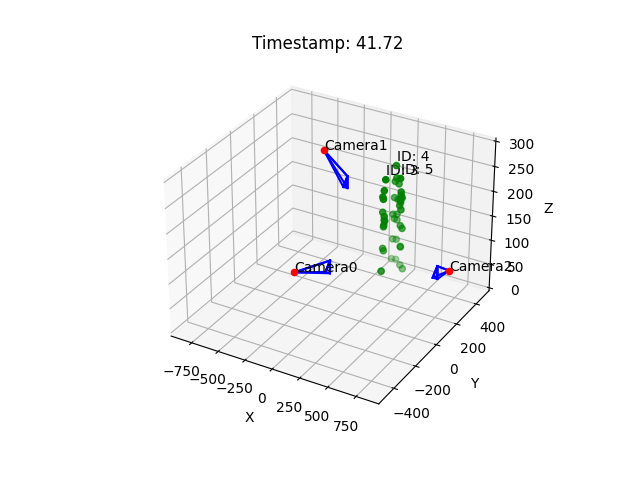

In [11]:
ori_wcx = np.mean(world_ltrb[0::2])
ori_wcy = np.mean(world_ltrb[1::2])
world_ltrb_mean_cen = world_ltrb.copy()
world_ltrb_mean_cen[0::2] -= ori_wcx
world_ltrb_mean_cen[1::2] -= ori_wcy
camera_id_list = list(camera_id_list)

#maximum_person_to_plot = 25
#cmap = plt.get_cmap('viridis')
#slicedCM = cmap(np.linspace(0, 1, maximum_person_to_plot)) 

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim3d(world_ltrb_mean_cen[0], world_ltrb_mean_cen[2])
ax.set_ylim3d(world_ltrb_mean_cen[1], world_ltrb_mean_cen[3])
ax.set_zlim3d(0, 300)
timestamp_to_plot = float(41.72)
ax.set_title(f'Timestamp: {timestamp_to_plot}')
show_cam_location_on_3d_plot(camera_id_list, calibration, magnitude=20, ax = ax)
scatter_points_arr = []
person_ID_list = []
for pose_index in range(len(poses_3d_all_timestamps[timestamp_to_plot])):
    this_pose = np.array(poses_3d_all_timestamps[timestamp_to_plot][pose_index]['points_3d'])
    this_pose[:, 0] -= ori_wcx
    this_pose[:, 1] -= ori_wcy
    
    keep = (
        (this_pose[:, 0] > world_ltrb_mean_cen[0])
        & (this_pose[:, 0] < world_ltrb_mean_cen[2])
        & (this_pose[:, 1] > world_ltrb_mean_cen[1])
        & (this_pose[:, 1] < world_ltrb_mean_cen[3])
    )
    this_pose = this_pose[keep]
    scatter_points_arr.append(this_pose)
    person_ID_list.append(str(poses_3d_all_timestamps[timestamp_to_plot][pose_index]['id']))
    ax.text(this_pose[-1,0], this_pose[-1,1], this_pose[-1,2]+10, f'ID: {person_ID_list[pose_index]}', color='black')
    
# Only do the scatter inside the loop
# top head is last keypoint 
scatter_points_arr = np.array(scatter_points_arr).reshape(-1,3)

ax.scatter(scatter_points_arr[:,0], scatter_points_arr[:,1], scatter_points_arr[:,2], c = 'g', marker='o')
# drawing updated values
plt.show()

3D animation with matplotlib

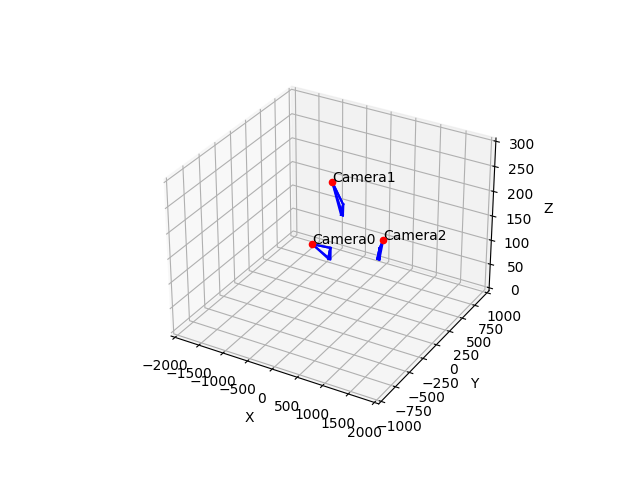

In [17]:
plot_3d_animation = True
if plot_3d_animation:
    ori_wcx = np.mean(world_ltrb[0::2])
    ori_wcy = np.mean(world_ltrb[1::2])
    world_ltrb_mean_cen = world_ltrb.copy()
    world_ltrb_mean_cen[0::2] -= ori_wcx
    world_ltrb_mean_cen[1::2] -= ori_wcy
    camera_id_list = list(camera_id_list)

    # Set up the figure and axis
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    #ax.set_xlim3d(world_ltrb_mean_cen[0], world_ltrb_mean_cen[2])
    #ax.set_ylim3d(world_ltrb_mean_cen[1], world_ltrb_mean_cen[3])
    ax.set_xlim3d(-2000, 2000)
    ax.set_ylim3d(-1000, 1000)
    ax.set_zlim3d(0, 300)
        
    
    #show_cam_location_on_3d_plot(camera_3d_location, camera_look_at, magnitude=20, ax = ax)
    show_cam_location_on_3d_plot(camera_id_list, calibration, magnitude=20, ax = ax)
    scatter = ax.scatter([], [], [], c='g', marker='o')
    #person_ID_text = ax.text(0,0,0, s = '', color='black')
    
    # Animation update function
    def update(index):
        # Clear the previous frame
        scatter._offsets3d = ([], [], [])
        #person_ID_text.set_text('')
        #person_ID_text.set_position((0,0,0))
    
        timestamp_to_plot = list(poses_3d_all_timestamps.keys())[index]
        scatter_points_list = []
        # Get the 3D points for the current frame
        if all(value is not None for value in poses_3d_all_timestamps[timestamp_to_plot]):
            for pose_index in range(len(poses_3d_all_timestamps[timestamp_to_plot])):
                this_pose = np.array(poses_3d_all_timestamps[timestamp_to_plot][pose_index]['points_3d'])
                this_pose[:, 0] -= ori_wcx
                this_pose[:, 1] -= ori_wcy
                
                keep = (
                    (this_pose[:, 0] > world_ltrb_mean_cen[0])
                    & (this_pose[:, 0] < world_ltrb_mean_cen[2])
                    & (this_pose[:, 1] > world_ltrb_mean_cen[1])
                    & (this_pose[:, 1] < world_ltrb_mean_cen[3])
                )
                #this_pose = this_pose[keep]
                scatter_points_list.append(this_pose)
                person_ID = str(poses_3d_all_timestamps[timestamp_to_plot][pose_index]['id'])
                                
                #person_ID_text.set_text(f'ID: {person_ID}')
                #person_ID_text.set_position((this_pose[-1,0], this_pose[-1,1], this_pose[-1,2]+10))
                
            scatter_points_arr = np.array(scatter_points_list).reshape(-1,3)
            scatter._offsets3d = (scatter_points_arr[:,0], scatter_points_arr[:,1], scatter_points_arr[:,2])
        
        # Set the plot title with the timestamp
        ax.set_title(f'Timestamp: {timestamp_to_plot}')
    
    # Create the animation
    animation = FuncAnimation(fig, update, len(poses_3d_all_timestamps), interval=20, repeat=False)

    # Show the animation
    plt.show()
